In [1]:
from keras.datasets import boston_housing

(train_data, train_targets),(test_data, test_targets) = boston_housing.load_data()

In [2]:
train_data.shape

(404, 13)

In [3]:
test_data.shape

(102, 13)

In [4]:
train_targets[:10]

array([15.2, 42.3, 50. , 21.1, 17.7, 18.5, 11.3, 15.6, 15.6, 14.4])

I've done exploratory data analysis on this dataset in the past. The notebook can be found [here](https://github.com/gary-loayza/Python-Data-Science-Tutorial/blob/master/Machine%20Learning%20Sections/Linear%20Regression/Boston%20Data%20Analysis.ipynb). I also performed multiple linear regression on the data which resulted in a model with a RMSE of about 5.3 thousand dollars and a **MAE of 3.8 thousand dollars**

## Preparing the data
It would be problematic to feed into a neural network values that all take wildly different ranges. The network might be able to automatically adapt to such heterogenous data, but it would definitely make learning more difficult.

A widespread best practice to deal with such data is to do **feature-wise normalization**: for each feature in the input data (a column in the input matrix), you subtract the mean of the feature and divide by the standard deviation, so that the feature is centered around 0 and has a unit standard deviation.

In [5]:
mean = train_data.mean(axis=0)
train_data -= mean

std = train_data.std(axis=0)
train_data /= std

# The quantities used for normalizing the test data are computed using the training data
# You should never use any quantity computed on the test data
test_data -= mean
test_data /= std

## Building the network
Because so few samples are available, you'll use a very small network with two hidden layers, each with 64 units.

In general, the less training data you have, the worse overfitting will be, and **using a small network is one way to mitigate overfitting.**

In [6]:
from keras import models
from keras import layers

# Because we'll need to instantiate the same model multiple times, we'll use a function to construct it
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    
    model.compile(optimizer='rmsprop',loss='mse', metrics=['mae'])
    return model

The networks ends with a single unit and no activation (it will be a linear layer). This is a typical setup for scalar regression (a regression where you're trying to predict a single continuous value). **Applying an activation function would constrain the range the output can take**; for instance a *sigmoid* function would only predict a value between 0 and 1.

Lastly, it's important to note that the network is compiled with the *mean squared error* loss function and monitoring *mean absolute error*, which we can use to compare to the previous linear analysis.

### Validating our approach using K-fold validation
To evaluate your network while you keep adjsuting its parameters (such as the number of epochs used for training), you could split the data into a training set and a valedation set as we have before. But because we have so few data points, the validation set would end up being very small. As a consequence, the validtaion scores might change a lot depending on which data points are selected for validation and training.

The best practice in such situations is to use **K-fold cross-validation**. To learn more about this topic, you can read [here](https://nbviewer.jupyter.org/github/gary-loayza/Statistical-Learning-Notebook/blob/master/5.%20Resampling%20Methods/Resampling%20Methods.ipynb#k-Fold-Cross-Validation). We will implement this now

In [7]:
import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []

for i in range(k):
    print('processing fold #', i)
    # Prepare validation data: data from partition number k
    val_data = train_data[i * num_val_samples : (i + 1)*num_val_samples]
    val_targets = train_targets[i * num_val_samples : (i + 1)*num_val_samples]
    
    # Prepares the training data: data from all other partitions
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples], train_data[(i + 1)*num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples], train_targets[(i + 1) * num_val_samples:]],
        axis=0)
    
    # Builds the Keras model
    model = build_model()
    
    # Trains the model in silent mode
    model.fit(partial_train_data, partial_train_targets, epochs=num_epochs, batch_size=1, verbose=0)
    
    # Evaluates model on the validation data
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [8]:
all_scores

[2.4271368980407715, 2.9683845043182373, 2.720827579498291, 2.4019837379455566]

In [9]:
np.mean(all_scores)

2.629583179950714

In this case, we're off by about $\$2,600$ on average, which is better than the initial linear model approach in my data science tutorial notebook, but it is still a large error when considering that the pricces range from $\$10,000$ to $\$50,000$.

Let's try training the network a bit longer: 500 epochs. To keep a record of how well the model does at each epoch, we'll modify the training ploop to save the per-epoch validation score log.

In [10]:
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print('processing fold #', i)
    # Prepare validation data: data from partition number k
    val_data = train_data[i * num_val_samples : (i + 1)*num_val_samples]
    val_targets = train_targets[i * num_val_samples : (i + 1)*num_val_samples]
    
    # Prepares the training data: data from all other partitions
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples], train_data[(i + 1)*num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples], train_targets[(i + 1) * num_val_samples:]],
        axis=0)
    
    # Builds the Keras model
    model = build_model()
    
    # Trains the model in silent mode
    history  = model.fit(
        partial_train_data,
        partial_train_targets,
        validation_data =(val_data,val_targets),
        epochs=num_epochs, batch_size=1, verbose=0)
    
    mae_history = history.history['val_mae']
    
    all_mae_histories.append(mae_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [11]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)
]

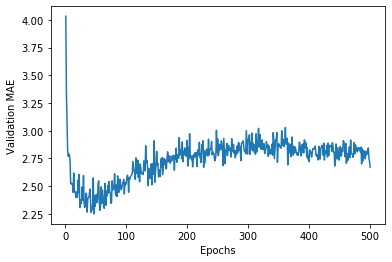

In [12]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show() 

We'll just clean this up a bit, dropping the first 10 points and replacing each point with an exponential moving average of the previous points, to obtain a smooth curve.

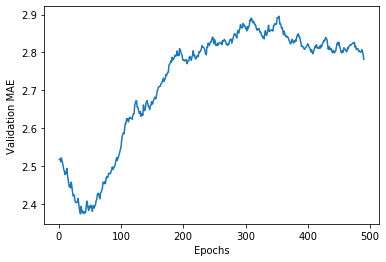

In [13]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show() 

According to this plot, validation MAE stops improving significantly after about 30 epochs. Past that point, you start overfitting.

Once you're finished tuning other parameters of the model (in addition to the number of epochs, you could also adjust the size of the hidden layers), you can train a final production model on all of the training data, with the best parameters, and then look at its performance on the test data.

In [14]:
model = build_model() # Get a fresh, compiled model
model.fit(train_data, train_targets,
          epochs=30, batch_size=16, verbose=0) # Trains on the entirety of the data

test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

4/4 [==============================] - 0s 1ms/step - loss: 20.3961 - mae: 2.8888


In [15]:
test_mae_score

2.888848066329956

The final result shows that the model is still off by about $\$2,800$